In [4]:
import pandas as pd
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats

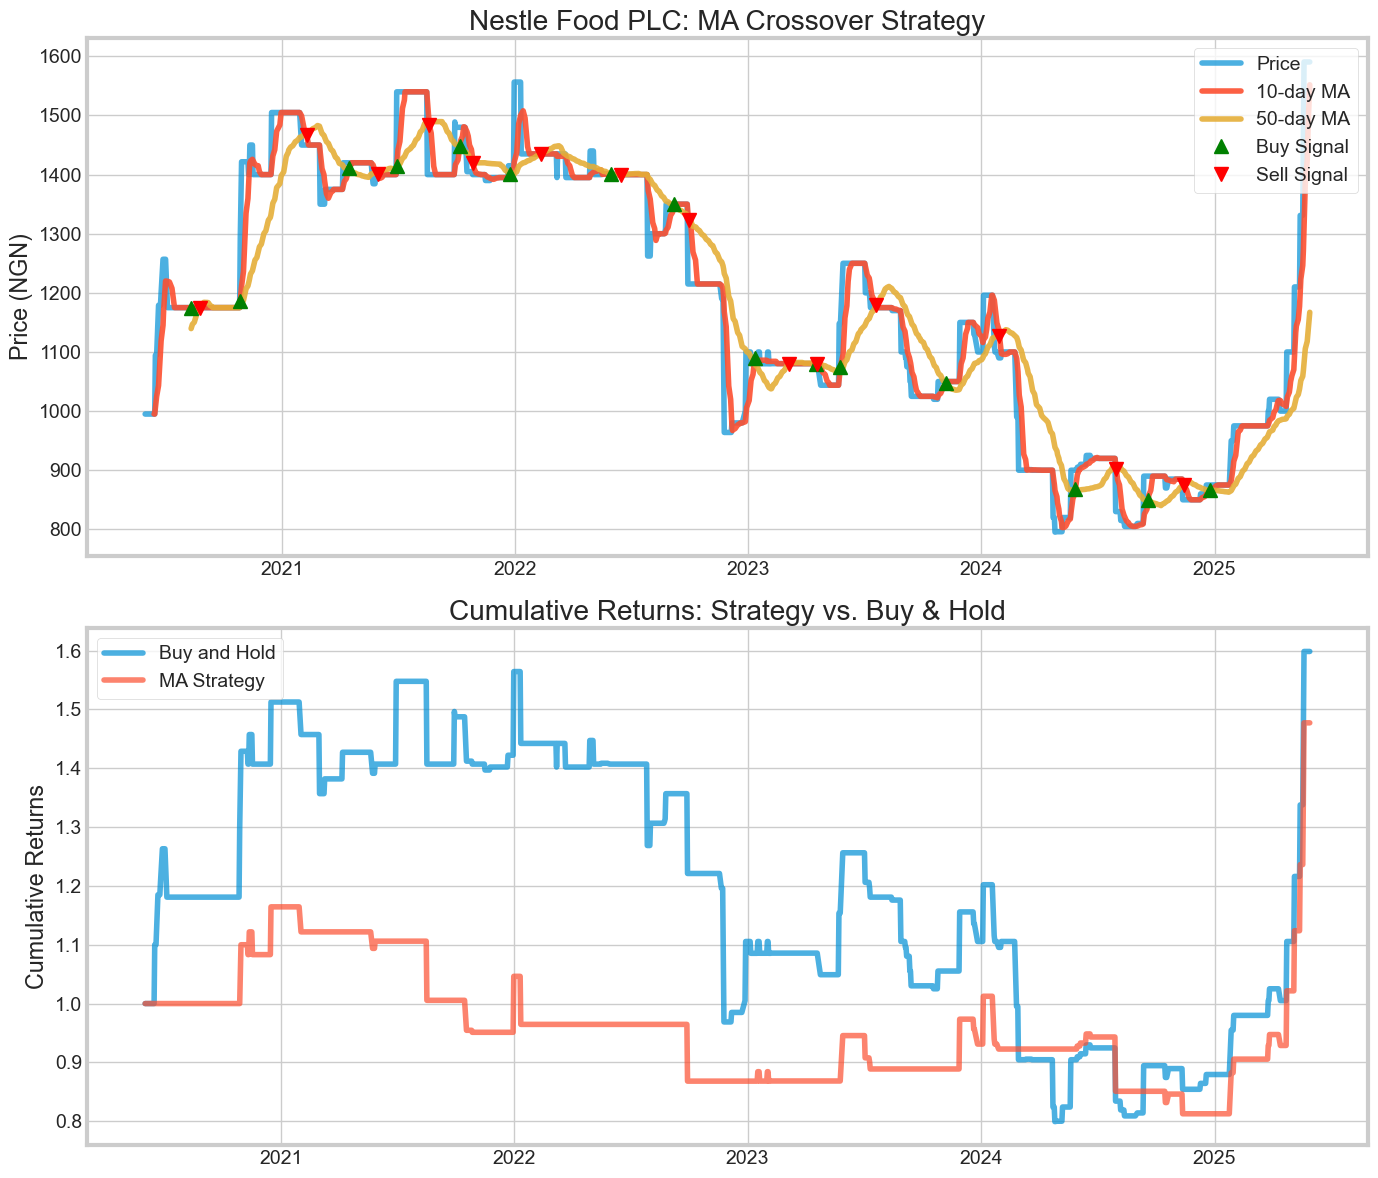

In [6]:
# === 1. Import Your CSV Data ===

# Raw string format to handle backslashes and spaces in the file path
file_path = r"C:\Users\moses\OneDrive\Desktop\Project Folder\Stock Data for Nestle Food PLC 2020 - 2025.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path, parse_dates=['Date'])

# Convert 'Price' column to numeric after removing commas
df['Price'] = df['Price'].replace(',', '', regex=True).astype(float)

# Set the 'Date' column as the index (optional but useful for time series)
df.set_index('Date', inplace=True)
# Set plot styles
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

# Sort by date just in case
df.sort_index(inplace=True)
# === 2. Calculate Moving Averages ===
df['MA10'] = df['Price'].rolling(window=10).mean()
df['MA50'] = df['Price'].rolling(window=50).mean()

# === 3. Generate Buy/Sell Signals ===
df['Signal'] = 0
df['Signal'] = np.where(df['MA10'] > df['MA50'], 1, 0)  # 1 = Buy, 0 = Hold/Sell
df['Position'] = df['Signal'].diff()  # 1 = Buy signal, -1 = Sell signal

# === 4. Calculate Returns ===
df['Returns'] = df['Price'].pct_change()
df['Strategy_Returns'] = df['Signal'].shift(1) * df['Returns']

# === 5. Calculate Cumulative Returns ===
df['Cumulative_Returns'] = (1 + df['Returns']).cumprod()
df['Strategy_Cumulative_Returns'] = (1 + df['Strategy_Returns']).cumprod()

# === 6. Plot the Results ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# --- Price Chart with MAs & Signals ---
ax1.plot(df.index, df['Price'], label='Price', alpha=0.7)
ax1.plot(df.index, df['MA10'], label='10-day MA', alpha=0.9)
ax1.plot(df.index, df['MA50'], label='50-day MA', alpha=0.9)

# Plot buy signals
ax1.plot(df[df['Position'] == 1].index,
         df['MA10'][df['Position'] == 1],
         '^', markersize=10, color='g', label='Buy Signal')

# Plot sell signals
ax1.plot(df[df['Position'] == -1].index,
         df['MA10'][df['Position'] == -1],
         'v', markersize=10, color='r', label='Sell Signal')

ax1.set_title('Nestle Food PLC: MA Crossover Strategy')
ax1.set_ylabel('Price (NGN)')
ax1.legend()
ax1.grid(True)

# --- Cumulative Returns Chart ---
ax2.plot(df.index, df['Cumulative_Returns'], label='Buy and Hold', alpha=0.7)
ax2.plot(df.index, df['Strategy_Cumulative_Returns'], label='MA Strategy', alpha=0.7)
ax2.set_title('Cumulative Returns: Strategy vs. Buy & Hold')
ax2.set_ylabel('Cumulative Returns')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [8]:
from scipy.stats import ttest_rel

# Drop NaNs to align both return series
returns_data = df[['Returns', 'Strategy_Returns']].dropna()

# Perform paired t-test
t_stat, p_value = ttest_rel(returns_data['Strategy_Returns'], returns_data['Returns'])

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Result: Statistically significant difference between strategy and buy-and-hold returns.")
else:
    print("Result: No statistically significant difference between strategy and buy-and-hold returns.") 

T-statistic: -0.3968
P-value: 0.6916
Result: No statistically significant difference between strategy and buy-and-hold returns.
